In [1]:
!pip install numpy==1.26.4 --force-reinstall
!pip install --upgrade matplotlib opencv-python scikit-learn

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profiling 4.17.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.7 which is incompatible.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.

Found 452 images. Processing 3 examples.

--- Processing CHNCXR_0001_0.png ---


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x78301c819b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


Running GMM...
GMM Metrics:
  Accuracy: 0.7228
  Precision: 0.4611
  Recall (Sensitivity): 0.7640
  F1-Score / Dice: 0.5751
  IoU (Jaccard): 0.4036
Running Mean Shift (this can be slow)...
Mean Shift Metrics:
  Accuracy: 0.3519
  Precision: 0.2707
  Recall (Sensitivity): 0.9682
  F1-Score / Dice: 0.4231
  IoU (Jaccard): 0.2683

--- Processing CHNCXR_0002_0.png ---
Running GMM...
GMM Metrics:
  Accuracy: 0.7501
  Precision: 0.4530
  Recall (Sensitivity): 0.7346
  F1-Score / Dice: 0.5604
  IoU (Jaccard): 0.3893
Running Mean Shift (this can be slow)...
Mean Shift Metrics:
  Accuracy: 0.4047
  Precision: 0.2641
  Recall (Sensitivity): 0.9766
  F1-Score / Dice: 0.4157
  IoU (Jaccard): 0.2624

--- Processing CHNCXR_0004_0.png ---
Running GMM...
GMM Metrics:
  Accuracy: 0.8004
  Precision: 0.5316
  Recall (Sensitivity): 0.8889
  F1-Score / Dice: 0.6653
  IoU (Jaccard): 0.4985
Running Mean Shift (this can be slow)...
Mean Shift Metrics:
  Accuracy: 0.8137
  Precision: 0.5518
  Recall (Sensitiv

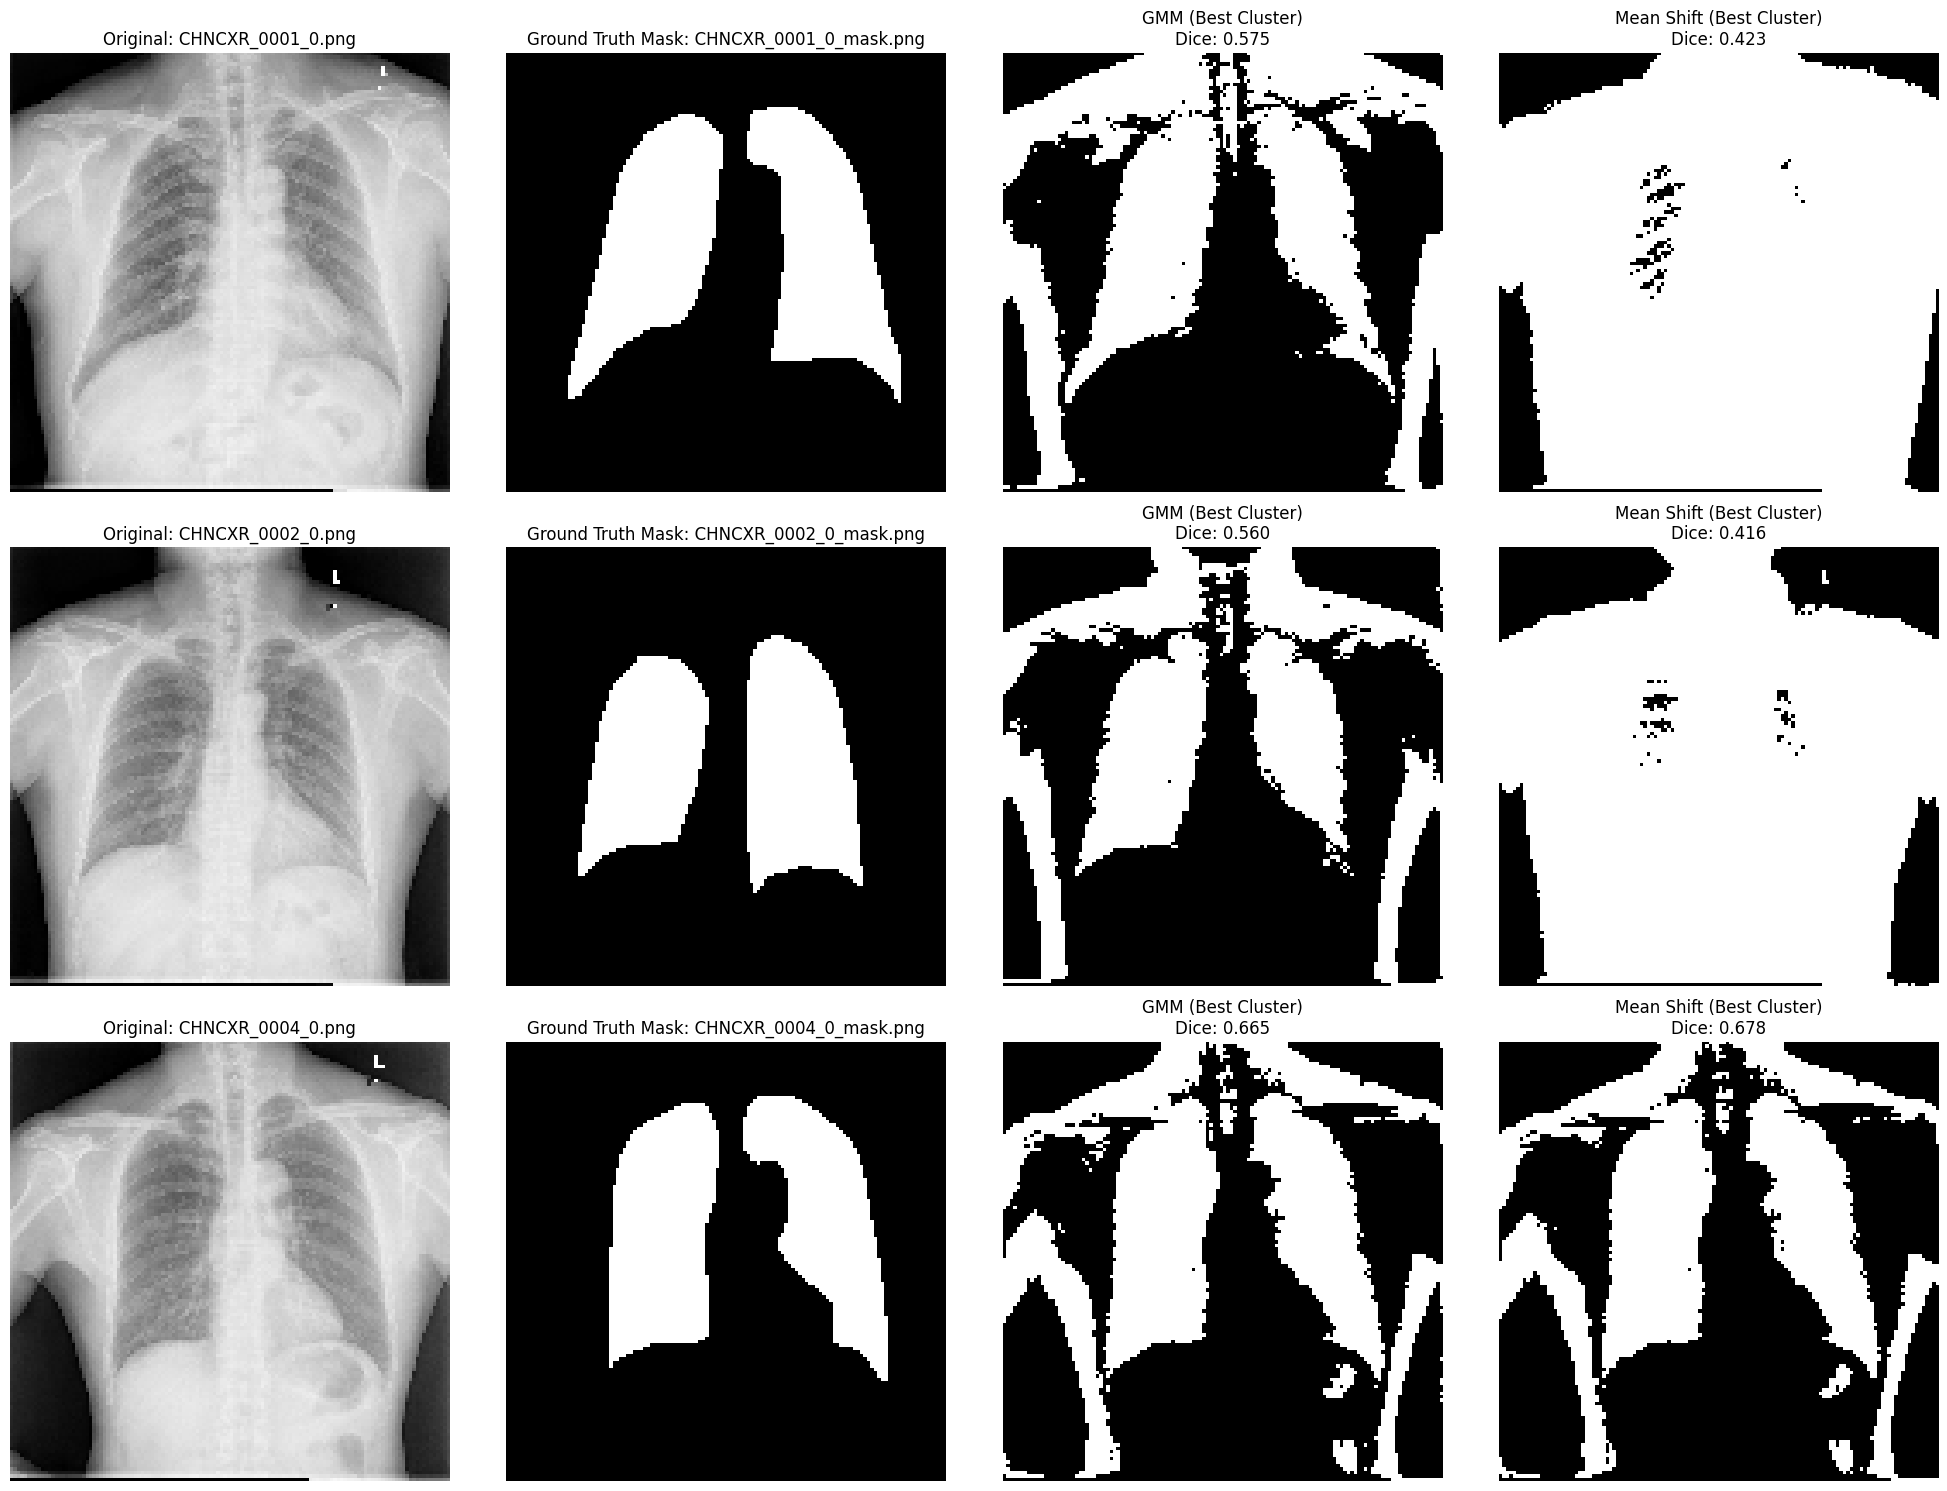

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, estimate_bandwidth
from pathlib import Path
# --- Import metrics ---
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    jaccard_score # This is Intersection over Union (IoU)
)

def find_best_cluster_and_calc_metrics(cluster_pred, gt_mask):
    """
    Finds the cluster ID that best matches the ground truth mask
    and calculates a dict of performance metrics.
    """
    # Flatten for sklearn metrics
    gt_flat = gt_mask.flatten()
    
    best_dice = -1
    best_binary_pred = None
    
    # Iterate through each cluster ID found by the algorithm
    cluster_ids = np.unique(cluster_pred)
    for cluster_id in cluster_ids:
        # Create a binary mask for the current cluster ID
        temp_pred = (cluster_pred == cluster_id).astype(int)
        temp_pred_flat = temp_pred.flatten()
        
        # Calculate Dice score (which is equivalent to F1 score)
        dice = f1_score(gt_flat, temp_pred_flat, zero_division=0)
        
        # If this cluster is better, save it
        if dice > best_dice:
            best_dice = dice
            best_binary_pred = temp_pred
            
    # Now, calculate all metrics using the best possible cluster
    if best_binary_pred is None:
        best_binary_pred = np.zeros_like(gt_mask)
        
    pred_flat = best_binary_pred.flatten()
    
    metrics = {
        "Accuracy": accuracy_score(gt_flat, pred_flat),
        "Precision": precision_score(gt_flat, pred_flat, zero_division=0),
        "Recall (Sensitivity)": recall_score(gt_flat, pred_flat, zero_division=0),
        "F1-Score / Dice": best_dice if best_dice != -1 else 0.0,
        "IoU (Jaccard)": jaccard_score(gt_flat, pred_flat, zero_division=0)
    }
    
    return metrics, best_binary_pred


def run_unsupervised_demo_multiple():
    """
    Loads images, applies clustering, compares to ground truth masks,
    and prints performance metrics.
    """
    
    # --- 1. Configuration (Updated Paths) ---
    TRAIN_DIR = Path("/kaggle/input/pc3-data/PC3_data_split/train")
    IMAGE_DIR = TRAIN_DIR / "images"
    MASK_DIR = TRAIN_DIR / "masks"
    
    NUM_EXAMPLES_TO_SHOW = 3
    IMG_HEIGHT, IMG_WIDTH = 128, 128

    # --- 2. Find Images (Handles multiple extensions) ---
    try:
        extensions = ["*.png", "*.jpg", "*.jpeg", "*.tif"]
        all_image_paths = []
        for ext in extensions:
            all_image_paths.extend(sorted(list(IMAGE_DIR.glob(ext))))
        
        if not all_image_paths:
            raise IndexError("No images found.")
        print(f"Found {len(all_image_paths)} images. Processing {NUM_EXAMPLES_TO_SHOW} examples.")
    except IndexError as e:
        print(f"Error: {e} in {IMAGE_DIR}")
        print("Please check your DATA_DIR path.")
        return

    # --- 3. Create Figure ---
    # 4 columns: Original, GT Mask, GMM Result, Mean Shift Result
    plt.figure(figsize=(20, NUM_EXAMPLES_TO_SHOW * 5)) # 20 wide, 5 tall per row

    # --- 4. Process and Plot in a Loop ---
    for i in range(NUM_EXAMPLES_TO_SHOW):
        if i >= len(all_image_paths):
            print("Reached end of image list.")
            break
            
        sample_image_path = Path(all_image_paths[i])
        img_name = sample_image_path.name
        img_stem = sample_image_path.stem # e.g., "CHNCXR_0001_0"
        print(f"\n--- Processing {img_name} ---")

        # --- Load and Prepare Image ---
        image = cv2.imread(str(sample_image_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image at {sample_image_path}, skipping.")
            continue
            
        image_resized = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        pixel_features = image_resized.reshape(-1, 1)

        # --- Load and Prepare Ground Truth Mask (NEW ROBUST LOGIC) ---
        mask_path = None
        search_extensions = [".png", ".jpg", ".jpeg", ".tif"]
        
        # 1. Try to find a mask with the exact same stem
        for ext in search_extensions:
            potential_path = MASK_DIR / f"{img_stem}{ext}"
            if potential_path.exists():
                mask_path = potential_path
                break
        
        # 2. Fallback: Try to find a mask with "_mask" suffix
        if mask_path is None:
            for ext in search_extensions:
                potential_path = MASK_DIR / f"{img_stem}_mask{ext}"
                if potential_path.exists():
                    mask_path = potential_path
                    break
        
        # 3. Read the mask if found
        gt_mask = None
        if mask_path:
            gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            
        if gt_mask is None:
            print(f"Failed to find or load mask for image {img_name} (stem: {img_stem}), skipping.")
            continue
        
        gt_mask_resized = cv2.resize(gt_mask, (IMG_WIDTH, IMG_HEIGHT))
        # Binarize the mask
        gt_mask_binary = (gt_mask_resized > 128).astype(int)


        # --- 5. Gaussian Mixture Model (GMM) ---
        print("Running GMM...")
        gmm = GaussianMixture(n_components=3, random_state=42)
        gmm_labels = gmm.fit_predict(pixel_features)
        segmented_gmm = gmm_labels.reshape(IMG_HEIGHT, IMG_WIDTH)
        
        # Calculate metrics for GMM
        gmm_metrics, gmm_best_pred = find_best_cluster_and_calc_metrics(segmented_gmm, gt_mask_binary)
        print("GMM Metrics:")
        for key, val in gmm_metrics.items():
            print(f"  {key}: {val:.4f}")

        # --- 6. Mean Shift ---
        print("Running Mean Shift (this can be slow)...")
        bandwidth = estimate_bandwidth(pixel_features, quantile=0.2, n_samples=1000)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms_labels = ms.fit_predict(pixel_features)
        segmented_ms = ms_labels.reshape(IMG_HEIGHT, IMG_WIDTH)
        
        # Calculate metrics for Mean Shift
        ms_metrics, ms_best_pred = find_best_cluster_and_calc_metrics(segmented_ms, gt_mask_binary)
        print("Mean Shift Metrics:")
        for key, val in ms_metrics.items():
            print(f"  {key}: {val:.4f}")

        # --- 7. Plot This Row ---
        
        # Plot Original (Column 1)
        plt.subplot(NUM_EXAMPLES_TO_SHOW, 4, i * 4 + 1)
        plt.imshow(image_resized, cmap='gray')
        plt.title(f"Original: {img_name}")
        plt.axis('off')

        # Plot Ground Truth (Column 2)
        plt.subplot(NUM_EXAMPLES_TO_SHOW, 4, i * 4 + 2)
        plt.imshow(gt_mask_binary, cmap='gray')
        plt.title(f"Ground Truth Mask: {mask_path.name}")
        plt.axis('off')

        # Plot GMM (Column 3)
        plt.subplot(NUM_EXAMPLES_TO_SHOW, 4, i * 4 + 3)
        plt.imshow(gmm_best_pred, cmap='gray')
        plt.title(f"GMM (Best Cluster)\nDice: {gmm_metrics['F1-Score / Dice']:.3f}")
        plt.axis('off')

        # Plot Mean Shift (Column 4)
        plt.subplot(NUM_EXAMPLES_TO_SHOW, 4, i * 4 + 4)
        plt.imshow(ms_best_pred, cmap='gray')
        plt.title(f"Mean Shift (Best Cluster)\nDice: {ms_metrics['F1-Score / Dice']:.3f}")
        plt.axis('off')

    print("\nPlotting complete.")
    plt.tight_layout()
    plt.show()

# Run the demo
if __name__ == "__main__":
    run_unsupervised_demo_multiple()